# Comprehensive Analysis of Rental Property Data Using Linear Regression

This notebook aims to explore the dynamics of rental prices using linear regression analysis. The dataset comprises rental property listings from 2018 to 2023, including features such as location, size, amenities, and price. Our goal is to identify significant predictors of rental prices and understand the impact of various property features on price. This analysis will provide insights into the rental market, aiding investors, real estate professionals, and policy-makers in making informed decisions.

In [1]:
# Load necessary libraries
library(tidyverse)
library(ggplot2)
library(gridExtra)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [2]:
# Reading the dataset
data_rent <- read.csv("./rent_merge_2018_2023.csv", dec = ",", header = TRUE, sep = ";")
# Convert categorical variables to factors (dummy variables)
categorical_vars <- c('gym', 'field_quadra', 'elevator', 'furnished', 'swimming_pool')
data_rent[categorical_vars] <- lapply(data_rent[categorical_vars], as.factor)

# Quick summary to check the conversion
summary(data_rent[categorical_vars])

   gym        field_quadra elevator     furnished    swimming_pool
 0   :18775   0   :21146   0   :17380   0   :20002   0   :18805   
 1   : 4237   1   : 1866   1   : 5632   1   : 3010   1   : 4207   
 NA's:10198   NA's:10198   NA's:10198   NA's:10198   NA's:10198   

### Dataset Overview

The dataset, `rent_merge_2018_2023.csv`, includes detailed listings of rental properties. Key variables include square footage, number of bedrooms and bathrooms, presence of amenities (gym, swimming pool, furnished status), and rental price. We will preprocess the data to handle categorical variables appropriately and ensure it is ready for linear regression analysis.

In [3]:
data_rent <- read.csv("./rent_merge_2018_2023.csv", dec = ",", header = T, sep = ";")

### Preprocessing: Handling Categorical Variables

In preparation for linear regression, it's crucial to convert categorical variables into a format that can be utilized in the model. We treat amenities such as gyms, swimming pools, and furnishing status as dummy variables (0 or 1) to indicate their absence or presence. This conversion allows us to quantify their impact on rental prices effectively.

In [4]:
data_rent$gym <- as.factor(data_rent$gym)
data_rent$field_quadra <- as.factor(data_rent$field_quadra)
data_rent$elevator <- as.factor(data_rent$elevator)
data_rent$furnished <- as.factor(data_rent$furnished)
data_rent$swimming_pool <- as.factor(data_rent$swimming_pool)

### Treating the date column

In [5]:
data_rent$date <- as.Date(data_rent$date, format = "%d/%m/%Y")

### Filtering the years

In [6]:
data_2018 <- filter(data_rent, year(date) == 2018)
data_2019 <- filter(data_rent, year(date) == 2019)
data_2020 <- filter(data_rent, year(date) == 2020)
data_2021 <- filter(data_rent, year(date) == 2021)
data_2022 <- filter(data_rent, year(date) == 2022)
data_2023 <- filter(data_rent, year(date) == 2023)

### Multiple regression by years

In [7]:
params <- (price_real_month ~
  area_m2 +
    bedrooms +
    suite +
    bathrooms +
    garage +
    condo_real +
    metro_dist_km +
    gym +
    field_quadra +
    elevator +
    furnished +
    swimming_pool)
reg <- lm(params, data = data_rent)
reg_2018 <- lm(params, data = data_2018)
reg_2019 <- lm(params, data = data_2019)
reg_2020 <- lm(params, data = data_2020)
reg_2021 <- lm(params, data = data_2021)
reg_2022 <- lm(params, data = data_2022)

### Using the IQR methodology to analyze and remove outliers

In [8]:
remove_outliers <- function(data, col_y, desired_max_y = 0, col_price = "price_real_month", desired_max_price = 0, default_multiplier = 1.5) {
  # Calculate the IQR for area and price
  Q1_y <- quantile(data[[col_y]], 0.25)
  Q3_y <- quantile(data[[col_y]], 0.75)
  IQR_y <- Q3_y - Q1_y

  Q1_price <- quantile(data[[col_price]], 0.25)
  Q3_price <- quantile(data[[col_price]], 0.75)
  IQR_price <- Q3_price - Q1_price

  # Calculate custom multipliers based on the desired maximum values
  multiplier_y <- (desired_max_y - Q3_y) / IQR_y
  multiplier_price <- (desired_max_price - Q3_price) / IQR_price

  # Use the larger of the calculated multipliers or the default 1.5, whichever is greater
  multiplier_y <- max(multiplier_y, default_multiplier)
  multiplier_price <- max(multiplier_price, default_multiplier)

  # Define the upper bounds using the custom or default multipliers
  upper_bound_y <- Q3_y + multiplier_y * IQR_y
  upper_bound_price <- Q3_price + multiplier_price * IQR_price

  # Define the lower bounds
  lower_bound_y <- Q1_y - multiplier_y * IQR_y
  lower_bound_price <- Q1_price - multiplier_price * IQR_price

  # Filter out the outliers
  data_filtered <- subset(data, data[[col_y]] >= lower_bound_y &
    data[[col_y]] <= upper_bound_y &
    data[[col_price]] >= lower_bound_price &
    data[[col_price]] <= upper_bound_price)

  return(data_filtered)
}


### Analysis with and without outlier

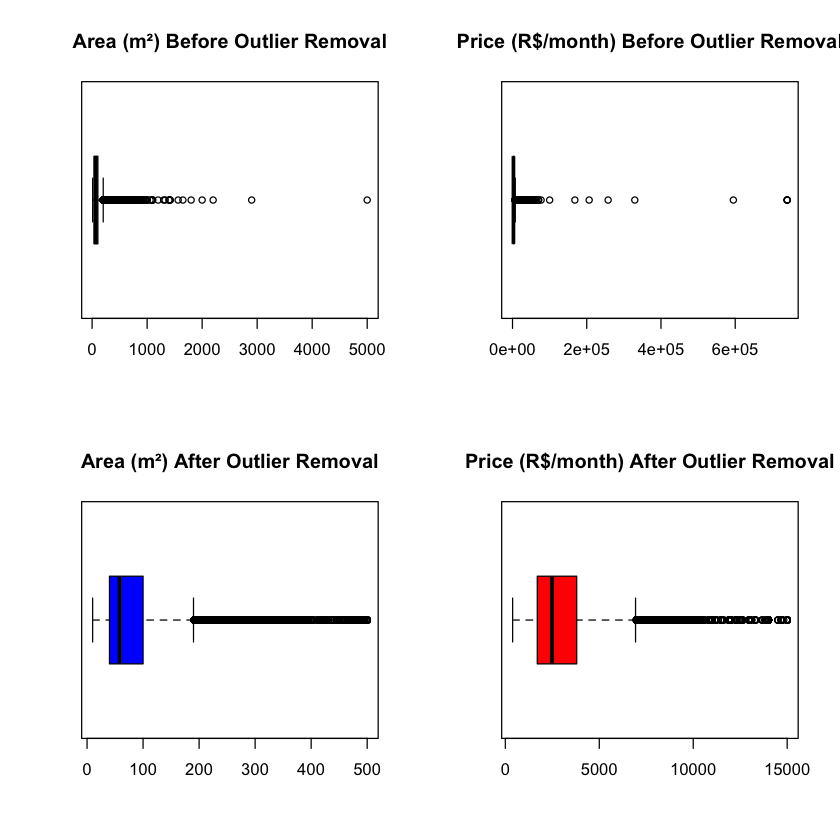

In [9]:
# Plot the boxplots for area_m2 before and after outlier removal
par(mfrow = c(2, 2)) # Set up the plotting area to have 2 rows and 2 columns

# filtering outliers
data_filtered <- remove_outliers(data = data_rent, col_y = "area_m2", desired_max_y = 500, desired_max_price = 15000)

# Area before outlier removal
boxplot(data_rent$area_m2, main = "Area (m²) Before Outlier Removal", horizontal = TRUE, col = "blue")
# Price before outlier removal
boxplot(data_rent$price_real_month, main = "Price (R$/month) Before Outlier Removal", horizontal = TRUE, col = "red")

# Area after outlier removal
boxplot(data_filtered$area_m2, main = "Area (m²) After Outlier Removal", horizontal = TRUE, col = "blue")

# Price after outlier removal
boxplot(data_filtered$price_real_month, main = "Price (R$/month) After Outlier Removal", horizontal = TRUE, col = "red")

### Plot graphs removing outlier using IQR to do it

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


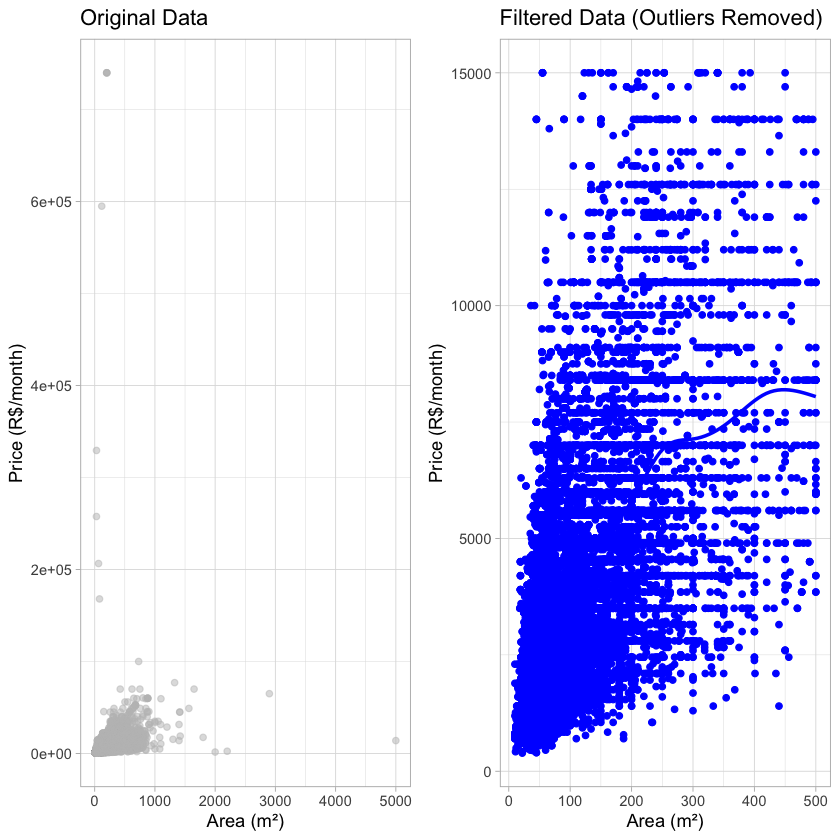

In [10]:
# Plot for original data
p1 <- ggplot(data_rent, aes(x = area_m2, y = price_real_month)) +
  geom_point(color = "grey", alpha = 0.5) +
  labs(title = "Original Data",
       x = "Area (m²)",
       y = "Price (R$/month)") +
  theme_light()

# Plot for filtered data
p2 <- ggplot(data_filtered, aes(x = area_m2, y = price_real_month)) +
  geom_point(color = "blue") +
  geom_smooth(method = "auto", se = FALSE, color = "blue") +
  labs(title = "Filtered Data (Outliers Removed)",
       x = "Area (m²)",
       y = "Price (R$/month)") +
  theme_light()

# Arrange the plots side by side
grid.arrange(p1, p2, ncol = 2)


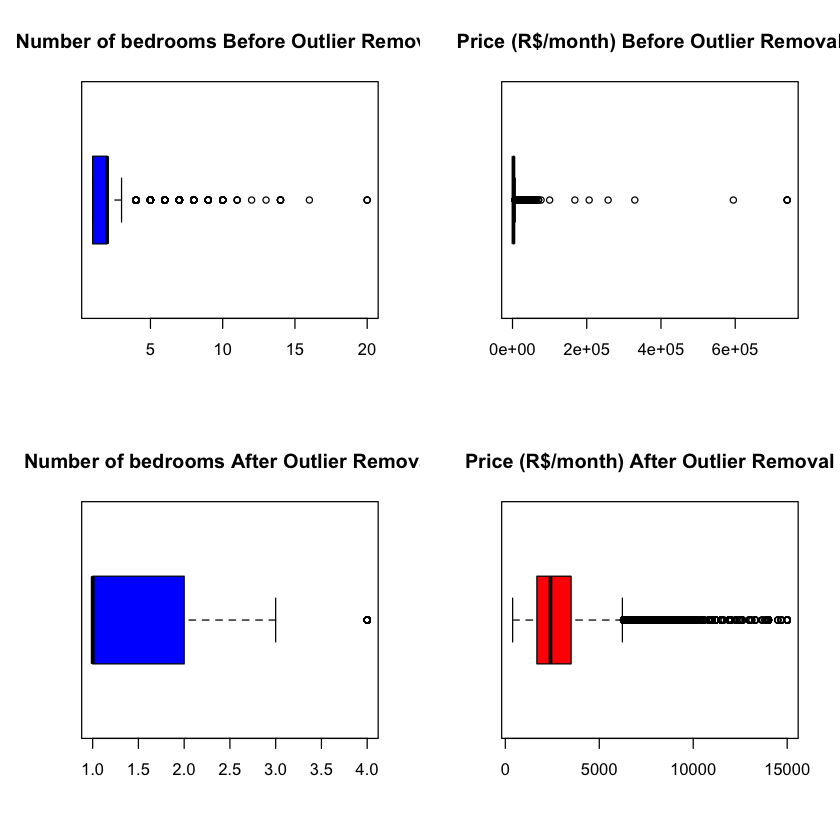

In [11]:
# Plot the boxplots for bedrooms before and after outlier removal
par(mfrow = c(2, 2)) # Set up the plotting area to have 2 rows and 2 columns

# filtering outliers
data_filtered <- remove_outliers(data = data_rent, col_y = "bedrooms", desired_max_y = 4, desired_max_price = 15000)

# Number of bedrooms before outlier removal
boxplot(data_rent$bedrooms, main = "Number of bedrooms Before Outlier Removal", horizontal = TRUE, col = "blue")

# Price before outlier removal
boxplot(data_rent$price_real_month, main = "Price (R$/month) Before Outlier Removal", horizontal = TRUE, col = "red")

# Number of bedrooms after outlier removal
boxplot(data_filtered$bedrooms, main = "Number of bedrooms After Outlier Removal", horizontal = TRUE, col = "blue")

# Price after outlier removal
boxplot(data_filtered$price_real_month, main = "Price (R$/month) After Outlier Removal", horizontal = TRUE, col = "red")

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `smooth.construct.cr.smooth.spec()`:
! x has insufficient unique values to support 10 knots: reduce k.”


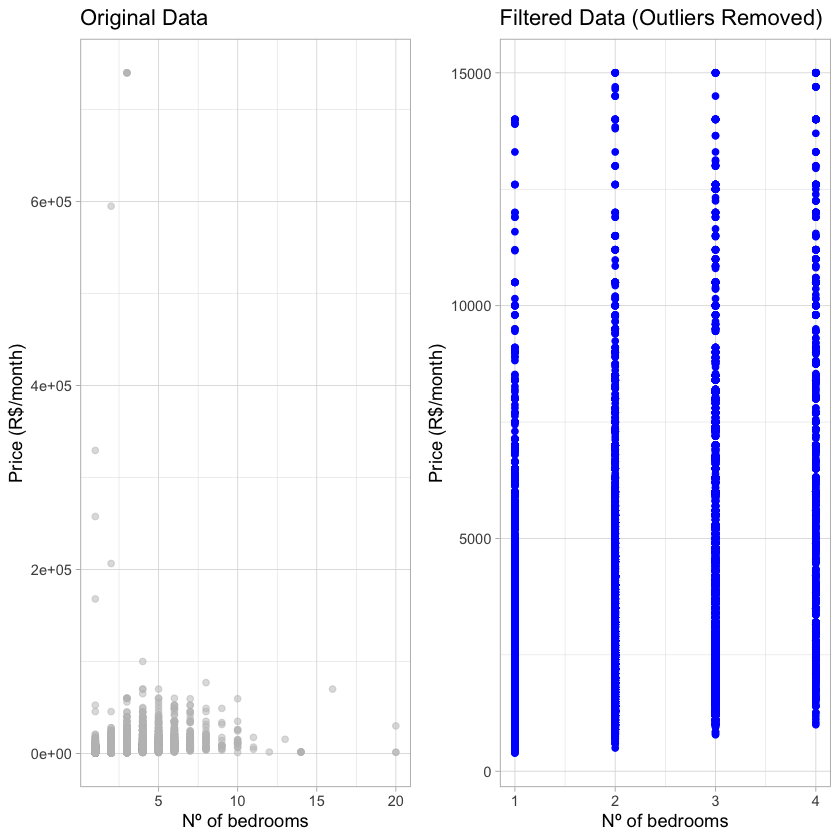

In [12]:
# Plot for original data
p1 <- ggplot(data_rent, aes(x = bedrooms, y = price_real_month)) +
  geom_point(color = "grey", alpha = 0.5) +
  labs(title = "Original Data",
       x = "Nº of bedrooms",
       y = "Price (R$/month)") +
  theme_light()

# Plot for filtered data
p2 <- ggplot(data_filtered, aes(x = bedrooms, y = price_real_month)) +
  geom_point(color = "blue") +
  geom_smooth(method = "auto", se = FALSE, color = "blue") +
  labs(title = "Filtered Data (Outliers Removed)",
       x = "Nº of bedrooms",
       y = "Price (R$/month)") +
  theme_light()

# Arrange the plots side by side
grid.arrange(p1, p2, ncol = 2)